# Extending Ibis Part 1: Adding a New Elementwise Expression

There are two parts of ibis that users typically want to extend:

1. Expressions (for example, by adding a new operation)
1. Backends

This notebook will show you how to add a new elementwise operation--`sha1`--to an existing backend (PostgreSQL).

## Description

We're going to add a **`sha1`** method to ibis. [SHA1](https://en.wikipedia.org/wiki/SHA-1) is a hash algorithm, employed in systems such as git.

## Step 1: Define the Operation

Let's define the `sha` operation as a function that takes one string input argument and returns a hexidecimal string.

```haskell
sha1 :: String -> String
```

In [1]:
import ibis.expr.datatypes as dt
import ibis.expr.rules as rlz

from ibis.expr.operations import ValueOp, Arg


class SHA1(ValueOp):
    arg = Arg(rlz.string)
    output_type = rlz.shape_like('arg', 'string')

We just defined a `SHA1` class that takes one argument of type string or binary, and returns a binary. This matches the description of the function provided by BigQuery.

## Step 2: Define the API

Because we know the output type of the operation, to make an expression out of ``SHA1`` we simply need to construct it and call its `ibis.expr.types.Node.to_expr` method.

We still need to add a method to `StringValue` and `BinaryValue` (this needs to work on both scalars and columns).

When you add a method to any of the expression classes whose name matches `*Value` both the scalar and column child classes will pick it up, making it easy to define operations for both scalars and columns in one place.

We can do this by defining a function and assigning it to the appropriate class
of expressions.


In [2]:
from ibis.expr.types import StringValue, BinaryValue


def sha1(string_value):
    return SHA1(string_value).to_expr()


StringValue.sha1 = sha1

## Interlude: Create some expressions with `sha1`

In [3]:
import ibis

In [4]:
t = ibis.table([('string_col', 'string')], name='t')

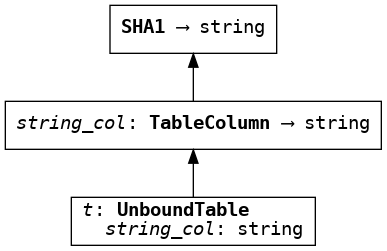

In [5]:
t.string_col.sha1()

## Step 3: Turn the Expression into SQL

In [6]:
import sqlalchemy as sa


@ibis.postgres.compiles(SHA1)
def compile_sha1(translator, expr):
    # pull out the arguments to the expression
    arg, = expr.op().args
    
    # compile the argument
    compiled_arg = translator.translate(arg)
    
    # return a SQLAlchemy expression that calls into the PostgreSQL pgcrypto extension
    return sa.func.encode(sa.func.digest(compiled_arg, 'sha1'), 'hex')

## Step 4: Putting it all Together

### Connect to the `ibis_testing` database

**NOTE:**

To be able to execute the rest of this notebook you need to run the following command from your ibis clone:

```sh
make init
```

In [7]:
import ibis
con = ibis.postgres.connect(
    database='ibis_testing', user='postgres', host='postgres', password='postgres')

### Register the pgcrypto extension

See https://www.postgresql.org/docs/10/static/pgcrypto.html for details about this extension

In [8]:
# the output here is an AlchemyProxy instance that cannot iterate
# (because there's no output from the database) so we hide it with a semicolon
con.raw_sql('CREATE EXTENSION IF NOT EXISTS pgcrypto');

### Create and execute a `sha1` expression

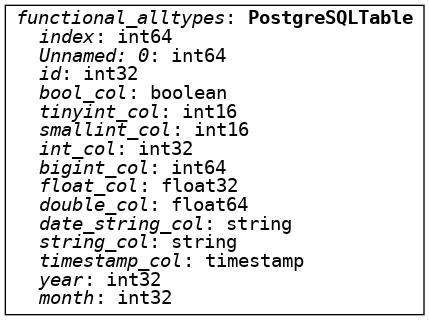

In [9]:
t = con.table('functional_alltypes')
t

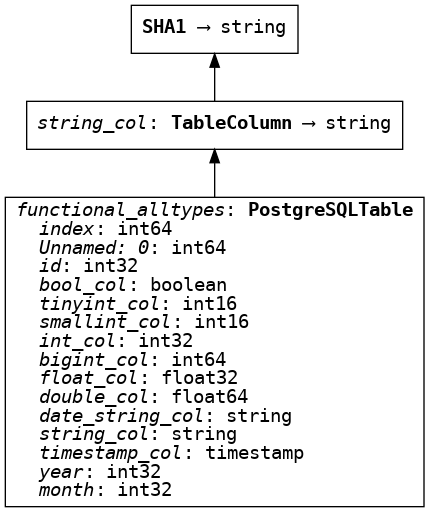

In [10]:
sha1_expr = t.string_col.sha1()
sha1_expr

In [11]:
sql_expr = sha1_expr.compile()
print(sql_expr)

SELECT encode(digest(t0.string_col, %(digest_1)s), %(encode_1)s) AS tmp 
FROM functional_alltypes AS t0


In [12]:
result = sha1_expr.execute()

In [13]:
result.head()

0    b6589fc6ab0dc82cf12099d1c2d40ab994e8410c
1    356a192b7913b04c54574d18c28d46e6395428ab
2    da4b9237bacccdf19c0760cab7aec4a8359010b0
3    77de68daecd823babbb58edb1c8e14d7106e83bb
4    1b6453892473a467d07372d45eb05abc2031647a
Name: tmp, dtype: object

Because we've defined our operation on `StringValue`, and not just on `StringColumn` we get operations on both string scalars *and* string columns for free

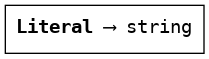

In [14]:
string_scalar = ibis.literal('abcdefg')
string_scalar

In [15]:
sha1_scalar = string_scalar.sha1()

In [16]:
con.execute(sha1_scalar)

'2fb5e13419fc89246865e7a324f476ec624e8740'